In [19]:
load('.RData')

In [20]:
library(FSelector)
library(RColorBrewer)
library(caret)

In [21]:
## Eliminar Mouse 3484
df <- df[df$Mouse != 3484, ]

## 1. Importance Gain

In [22]:
head(df)

,Mouse,Sample,Genotype,Treatment,Behavior,class,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,⋯,P3525_N,pCASP9_N,PSD95_N,SNCA_N,Ubiquitin_N,pGSK3B_Tyr216_N,SHH_N,pS6_N,SYP_N,CaNA_N
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
309_1,309,1,Control,Memantine,CS,cCSm,0.5036439,0.7471932,0.4301753,2.816329,⋯,0.2475378,1.603310,2.014875,0.1082343,1.0449792,0.8315565,0.1888517,0.1063052,0.4270992,1.675652
309_2,309,2,Control,Memantine,CS,cCSm,0.5146171,0.6890635,0.4117703,2.789514,⋯,0.2576322,1.671738,2.004605,0.1097485,1.0098831,0.8492704,0.2004036,0.1065922,0.4415813,1.743610
309_3,309,3,Control,Memantine,CS,cCSm,0.5091831,0.7302468,0.4183088,2.687201,⋯,0.2553430,1.663550,2.016831,0.1081962,0.9968476,0.8467087,0.1936845,0.1083031,0.4357769,1.926427
309_4,309,4,Control,Memantine,CS,cCSm,0.4421067,0.6170762,0.3586263,2.466947,⋯,0.2511031,1.484624,1.957233,0.1198832,0.9902247,0.8332768,0.1921119,0.1031838,0.3916910,1.700563
309_5,309,5,Control,Memantine,CS,cCSm,0.4349402,0.6174298,0.3588022,2.365785,⋯,0.2517730,1.534835,2.009109,0.1195244,0.9977750,0.8786678,0.2056042,0.1047838,0.4341538,1.839730
309_6,309,6,Control,Memantine,CS,cCSm,0.4475064,0.6281758,0.3673881,2.385939,⋯,0.2444853,1.507777,2.003535,0.1206872,0.9201782,0.8436793,0.1904695,0.1064762,0.4398331,1.816389


In [23]:
options(repr.plot.width = 12, repr.plot.height = 7)

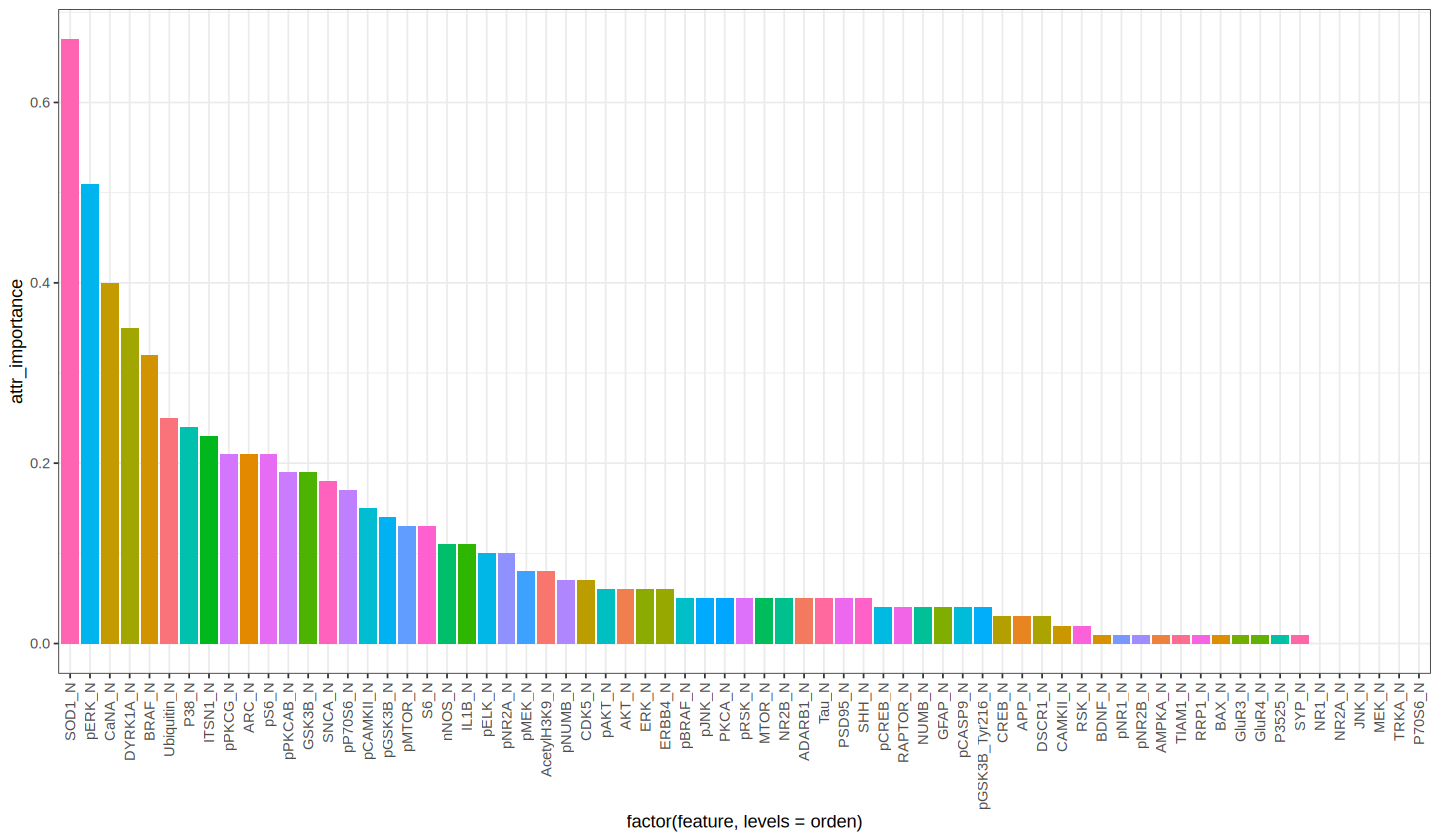

In [24]:
importance <- information.gain(Behavior~., df[, c('Behavior', proteinas)])
importance$attr_importance <- round(importance$attr_importance, 2)
importance$feature <- rownames(importance)
orden <- importance[order(importance$attr_importance, decreasing = TRUE), 'feature']

ggplot(data = importance, aes(x = factor(feature, levels = orden), 
                              y = attr_importance, fill = feature)) +
        geom_bar(stat = 'identity') +
        theme_bw() +
        theme(legend.position = 'none', axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
        

## 2. Remove Redundant Features

Data can contain attributes that are highly correlated with each other. Many methods perform better if highly correlated attributes are removed.

Generally, you want to remove attributes with an absolute correlation of 0.75 or higher.

In [25]:
correlationMatrix <- cor(df[, 7:75], use = 'pairwise.complete.obs')
highlyCorrelated <- findCorrelation(correlationMatrix, cutoff=0.75)
highCorrelatedColumns <- colnames(correlationMatrix[, highlyCorrelated])
highCorrelatedColumns

[1] "TRKA_N"   "MEK_N"    "BDNF_N"   "NR1_N"    "pNR2B_N"  "pNR1_N"  
 [7] "pJNK_N"   "pMTOR_N"  "NR2A_N"   "pMEK_N"   "JNK_N"    "NR2B_N"  
[13] "PKCA_N"   "CAMKII_N" "AMPKA_N"  "GSK3B_N"  "MTOR_N"   "TIAM1_N" 
[19] "RAPTOR_N" "pAKT_N"   "ARC_N"    "CREB_N"   "ITSN1_N"  "RSK_N"   
[25] "DYRK1A_N" "pERK_N"   "Tau_N"

## 3. Rank Features By Importance
The importance of features can be estimated from data by building a model. Some methods like decision trees have a built in mechanism to report on variable importance. For other algorithms, the importance can be estimated using a ROC curve analysis conducted for each attribute.

In [26]:
fit_control <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           ## repeated ten times
                           repeats = 10,
                           classProbs=TRUE)

In [47]:
set.seed(57)
index <- createDataPartition(df$Behavior, p = 0.75, list = FALSE)
train_data <- df[index,]
test_data <- df[-index,]
sprintf("The trainining set contains %d rows", nrow(train_data))
sprintf("The test set contains %d rows", nrow(test_data))

table(train_data$class)

[1] "The trainining set contains 794 rows"

[1] "The test set contains 264 rows"


cCSm cCSs cSCm cSCs tCSm tCSs tSCm tSCs 
 117   90  112  103   97   76  105   94 

In [48]:
## Centrado, escalado, e imputacion de NA por Knn
preProcValues <- preProcess(train_data, method = c('center', 'scale', 'knnImpute'))
trainTransformed <- predict(preProcValues, train_data)
testTransformed <- predict(preProcValues, test_data)

In [56]:
#### OJO ### Varios minutos de computacion
model <- train(Behavior~., 
               data = trainTransformed[, c('Behavior', proteinas)], 
               method='rf', metric = 'Accuracy', trControl=fit_control)

In [57]:
model

Random Forest 

794 samples
 69 predictor
  2 classes: 'CS', 'SC' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 714, 715, 715, 715, 714, 715, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.9997484  0.9994964
  35    1.0000000  1.0000000
  69    0.9940775  0.9881272

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 35.

rf variable importance

  only 20 most important variables shown (out of 69)

             Overall
SOD1_N      232.5168
pERK_N       85.1279
CaNA_N       37.7425
DYRK1A_N     13.7746
BRAF_N        7.2401
ARC_N         2.2829
ERK_N         2.2218
Ubiquitin_N   1.7726
pS6_N         1.3127
P38_N         1.1736
ITSN1_N       1.1268
Tau_N         0.9747
pPKCAB_N      0.8414
GSK3B_N       0.7871
nNOS_N        0.7317
pGSK3B_N      0.6534
TRKA_N        0.4856
pJNK_N        0.4208
pMEK_N        0.2877
GFAP_N        0.2857


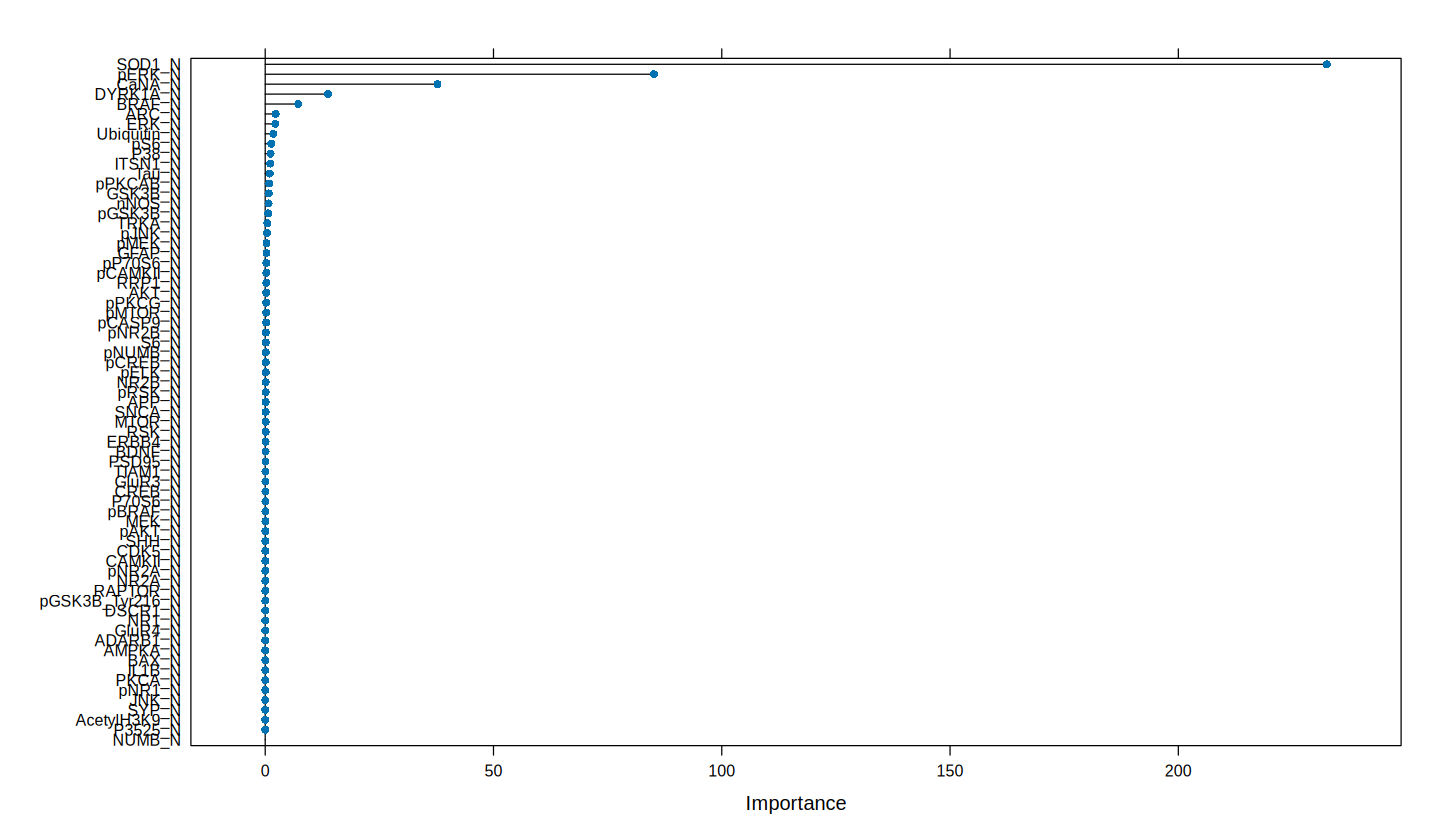

In [58]:
importance <- varImp(model, scale=FALSE)
print(importance)
plot(importance)

## 4. Recursive Feature Elimination

In [54]:
rfe_control <- rfeControl(functions=rfFuncs, method="cv", number=10)

In [99]:
#Mucho tiempo de computación
#results <- rfe(df_wna.sc[, 1:72], df_wna.sc[, 73], sizes=c(1:72), rfeControl=rfe_control)

In [74]:
selected_variables <- orden[1:10]

In [75]:
save.image()